# 영화 관객수 예측

**title** : 영화의 제목  

**distributor** : 배급사  

**genre** : 장르  

**release_time** : 개봉일  

**time** : 상영시간(분)  

**screening_rat** : 상영등급  

**director** : 감독이름  

**dir_prev_bfnum** : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수  
(단 관객수가 알려지지 않은 영화 제외)  

**dir_prev_num** : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수  
(단 관객수가 알려지지 않은 영화 제외)  

**num_staff** : 스텝수  

**num_actor** : 주연배우수  

**box_off_num** : 관객수  


# 1. 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

train = pd.read_csv('../data/movies_train.csv')
test = pd.read_csv('../data/movies_test.csv')
submission = pd.read_csv('../data/submission.csv')

#### Light GBM
LightGBM은 XGBoost와 함께 부스팅 계열 알고리즘에 각광받는 모델입니다.

XGBoost의 경우도 물론 GBM 보다 학습속도가 빠르지만 GridSearchCH로 하이퍼 파라미터를 튜닝하기에는 매우 많은 시간이 걸린다는 단점이 존재합니다.

 
LightGBM은 XGBoost와 비교해 큰 예측 성능 차이를 보이지 않으면서 학습 시간을 상당히 단축시킨 모델입니다.

 
LightGBM은 이러한 장점을 가지고 있지만 공식 문서에 따르면 일반적으로 10,000 건 이하의 데이터 세트를 다루는 경우 과적합 문제가 발생하기 쉽다는 단점이 있습니다.

# 2. EDA

In [2]:
train.info()

# dir_prev_bfnum 컬럼에 결측치가 330개 있음을 알 수 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [3]:
test.info()

# dir_prev_bfnum 컬럼에 결측치가 136개 있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [4]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        243 non-null    object
 1   box_off_num  243 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ KB


In [5]:
train.head()

# 장르들이 하나씩 나뉘어져 있다!

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [6]:
pd.options.display.float_format = '{:.5f}'.format
# 숫자들이 지수표현식으로 나오는 게 싫어서 지수표현식을 제거했다.

test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,300529.00000,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,342700.25000,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4206610.66667,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,691342.00000,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,31738.00000,1,380,1


In [7]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [8]:
print(train.shape)
print(test.shape)
print(submission.shape)

(600, 12)
(243, 11)
(243, 2)


### 수치변수들 통계량 확인

In [9]:
train.describe().T
# .T 속성은 DataFrame에서 index와 column을 바꾼 형태의 DataFrame이다.

,count,mean,std,min,25%,50%,75%,max
time,600.00000,100.86333,18.09753,45.00000,89.00000,100.00000,114.00000,180.00000
dir_prev_bfnum,270.00000,1050442.89142,1791408.30346,1.00000,20380.00000,478423.62500,1286568.62500,17615314.00000
dir_prev_num,600.00000,0.87667,1.18341,0.00000,0.00000,0.00000,2.00000,5.00000
num_staff,600.00000,151.11833,165.65467,0.00000,17.00000,82.50000,264.00000,869.00000
num_actor,600.00000,3.70667,2.44689,0.00000,2.00000,3.00000,4.00000,25.00000
box_off_num,600.00000,708181.75167,1828005.85114,1.00000,1297.25000,12591.00000,479886.75000,14262766.00000


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
time,243.00000,109.79835,124.02271,40.00000,91.00000,104.00000,114.50000,2015.00000
dir_prev_bfnum,107.00000,891669.51604,1217341.45457,34.00000,62502.00000,493120.00000,1080849.58333,6173099.50000
dir_prev_num,243.00000,0.85185,1.20032,0.00000,0.00000,0.00000,1.00000,6.00000
num_staff,243.00000,159.31687,162.97661,0.00000,18.00000,105.00000,282.00000,776.00000
num_actor,243.00000,3.47737,2.11119,0.00000,2.00000,3.00000,4.00000,16.00000


### 장르별 관객 수
장르별로 그룹을 잡아 관객 수의 평균을 구하고 오름차순 정렬한다.

In [11]:
train[['genre', 'box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.00000
다큐멘터리,67172.25806
서스펜스,82611.00000
애니메이션,181926.66667
멜로/로맨스,425968.03846
미스터리,527548.17647
공포,590832.52381
드라마,625689.79186
코미디,1193914.00000


### 데이터 상관관계 확인
- 상관계수: 두 개의 변수가 같이 일어나는 강도를 나타내는 수치
- -1에서 1 사이의 값을 지닌다.
- -1이나 1인 수치는 현실 세계에서 관측되기 힘든 수치이다.
- 분야별로 기준을 정하는 것에 따라 달라지겠지만, 보통 0.4 이상이면 두 개의 변수간에 상관성이 있다고 얘기한다.

In [12]:
# 설정 초기화
pd.reset_option('display.float_format')

In [13]:
train.corr()
# 상관계수 숫자로 보기

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


<AxesSubplot:>

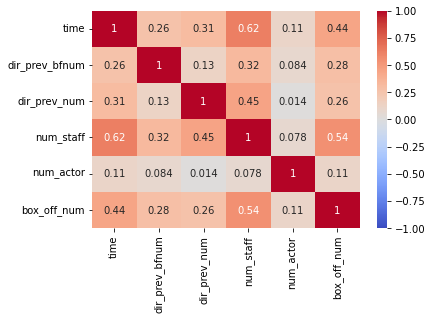

In [14]:
# 상관계수 히트맵으로 보기
sns.heatmap(train.corr(), vmin=-1, vmax=+1, annot=True, cmap='coolwarm')

# 왜인지는 모르겠으나 영화 제목과 스텝 수가 가장 높은 양의 상관관계를 이룬다.
# 스텝수와 관객 수가 두번째로 높은 양의 상관관계를 이룬다.
# 스텝수가 많으면 스케일이 큰 영화라서 그런가..?

# 주연배우 수는 영화 관객수나 다른 컬럼에도 영향을 주지 못하는 것으로 보인다.

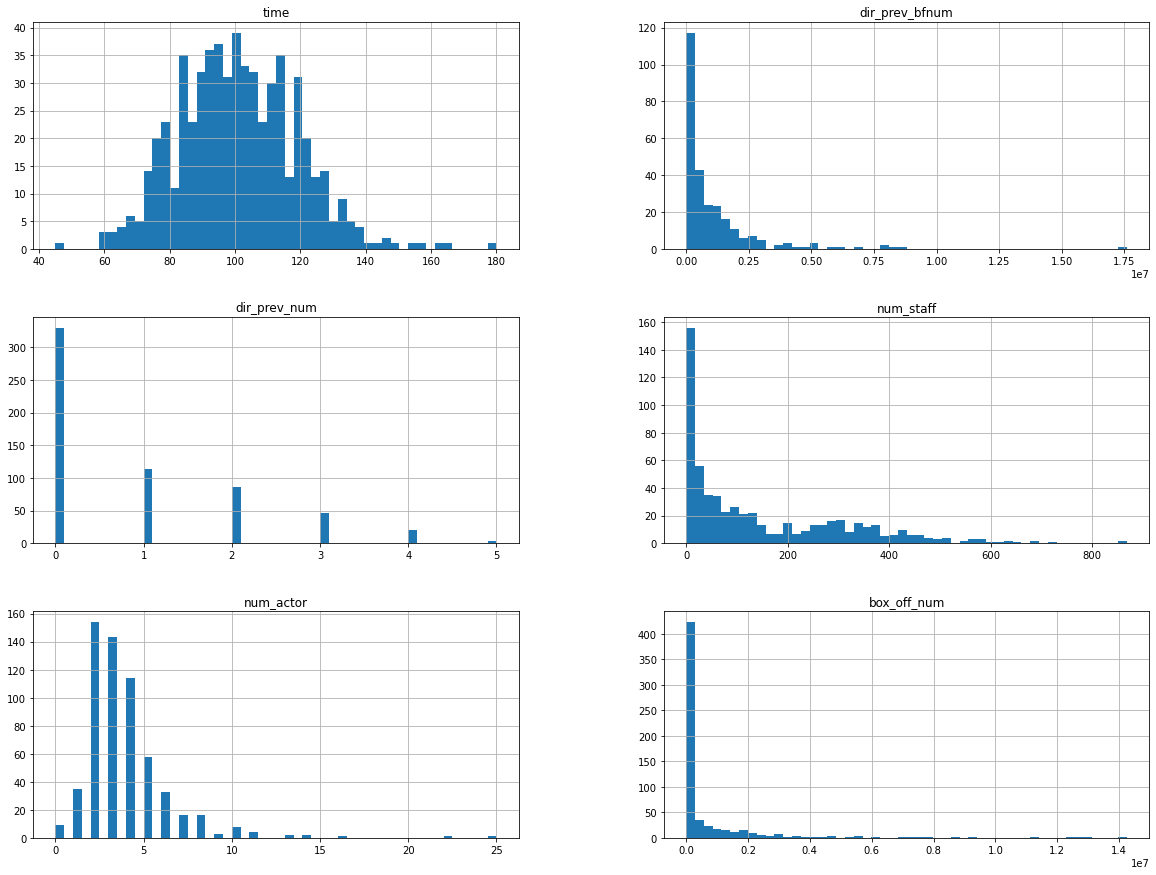

In [15]:
%matplotlib inline

train.hist(bins = 50, figsize = (20, 15))
plt.show()

# 오른쪽으로 꼬리가 긴 분포를 가진 변수에는 log 변환이 필요하다고 한다.

In [16]:
print(train['dir_prev_bfnum'].describe())
print(train['dir_prev_num'].describe())

count    2.700000e+02
mean     1.050443e+06
std      1.791408e+06
min      1.000000e+00
25%      2.038000e+04
50%      4.784236e+05
75%      1.286569e+06
max      1.761531e+07
Name: dir_prev_bfnum, dtype: float64
count    600.000000
mean       0.876667
std        1.183409
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        5.000000
Name: dir_prev_num, dtype: float64


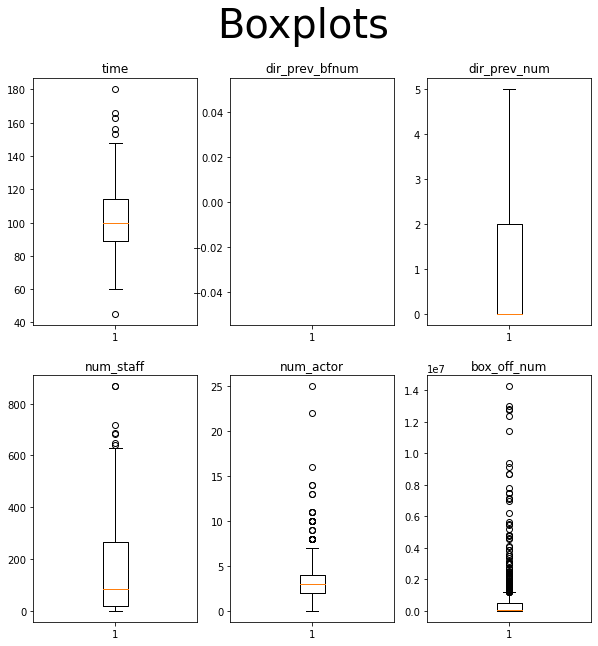

In [17]:
feature = ['time', 'dir_prev_bfnum', 'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num']

plt.figure(figsize=(10,10))
plt.suptitle("Boxplots", fontsize=40)

for i in range(len(feature)):
    plt.subplot(2,3,i+1)
    plt.title(feature[i])
    plt.boxplot(train[feature[i]])
plt.show()

# 3. 전처리

In [18]:
# 결측치 확인 (전체의 몇 %인지)
train.isna().sum() / 600

title             0.00
distributor       0.00
genre             0.00
release_time      0.00
time              0.00
screening_rat     0.00
director          0.00
dir_prev_bfnum    0.55
dir_prev_num      0.00
num_staff         0.00
num_actor         0.00
box_off_num       0.00
dtype: float64

In [19]:
# 'dir_prev_bfnum' 컬럼과 'dir_prev_num' 컬럼은 서로 연관이 크다고 생각
# 전에 제작했던 영화가 없으면 전에 제작했던 영화들의 평균 평점값이 0이기 때문

# 관객수가 알려지지 않은 영화라서 집계가 안되었을 수도 있다.
# dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수
#                (단 관객수가 알려지지 않은 영화 제외)

train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()   # 0

# 심플하게 'dir_prev_bfnum'이 결측치들은 모두 0이라고 보자.

0

### 결측치 처리

In [20]:
# 'dir_prev_bfnum' 컬럼의 결측치를 모두 0으로 채워준다.
train['dir_prev_bfnum'].fillna(0, inplace = True)

In [21]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [22]:
# test dataset에서도 'dir_prev_bfnum' 값이 결측치인 데이터들은
# 'dir_prev_num' 값도 0으로 나온다.
test[test['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [23]:
# train과 마찬가지로 'dir_prev_bfnum' 컬럼에 결측치 확인
test.isna().sum()   # 136

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [24]:
test['dir_prev_bfnum'].fillna(0, inplace = True)

In [25]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

### 배급사 전처리

In [26]:
train['distributor'].unique()

array(['롯데엔터테인먼트', '(주)쇼박스', '(주)NEW', '쇼박스(주)미디어플렉스', '백두대간',
       '유니버설픽쳐스인터내셔널코리아', '(주)두타연', '(주) 케이알씨지', '(주)콘텐츠 윙', '(주)키노아이',
       '(주)팝 파트너스', 'CJ E&M 영화부문', '(주) 영화제작전원사', 'CJ E&M Pictures',
       'CGV 무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ 엔터테인먼트', 'CGV아트하우스', '조이앤시네마',
       '인디플러그', '콘텐츠판다', '인디스토리', '(주)팝엔터테인먼트', '시네마서비스', '웃기씨네',
       '영화사 진진', '(주)레인보우 팩토리', '김기덕 필름', 'NEW', 'CJ CGV',
       '동국대학교 충무로영상제작센터', 'BoXoo 엔터테인먼트', '(주)마운틴픽쳐스', 'CGV 아트하우스',
       '메가박스(주)플러스엠', '골든타이드픽처스', '파이오니아21', '디 씨드', '드림팩트 엔터테인먼트', '시너지',
       '디마엔터테인먼트', '판다미디어', '(주)스톰픽쳐스코리아', '(주)예지림 엔터테인먼트', '(주) 영화사조제',
       '보람엔터테인먼트', '(주)시네마달', '노바엔터테인먼트', '(주)패스파인더씨앤씨', '(주)대명문화공장',
       '(주)온비즈넷', 'KT&G 상상마당', '무비꼴라쥬', '인벤트 디', '씨네그루(주)키다리이엔티',
       '스튜디오후크', '시네마 달', '나이너스엔터테인먼트(주)', 'THE 픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션 픽처스', '(주)이스트스카이필름', '필라멘트 픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴 픽처스', '(주)휘엔터테인먼트', '이십세기폭스코리아(주)', '(주)피터팬픽쳐스', '에스와이코마드',
       '(주)더픽쳐스', '오퍼스픽쳐스'

In [27]:
# 배급사에서 '(주)' 가 들어가 있으면 제거

train['distributor'] = train.distributor.str.replace('(주)','')
test['distributor'] = test.distributor.str.replace('(주)','')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_68700\1710428581.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['distributor'] = train.distributor.str.replace('(주)','')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_68700\1710428581.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['distributor'] = test.distributor.str.replace('(주)','')


In [28]:
train.head()   # '(주)'에서  '주' 만 제거됨 ㅋㅋ

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398
1,내부자들,()쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,()쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,()NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스()미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [29]:
# 배급사에서 특수문자 제거
# ^ 기호는 [] 범위 안에서 not을 나타낸다.
# 숫자, 알파벳, 한글 제외하고 나머지 제거

import re

train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [30]:
train['distributor'].unique()   # 깔끔해짐

array(['롯데엔터테인먼트', '쇼박스', 'NEW', '쇼박스미디어플렉스', '백두대간', '유니버설픽쳐스인터내셔널코리아',
       '두타연', '케이알씨지', '콘텐츠윙', '키노아이', '팝파트너스', 'CJEM영화부문', '영화제작전원사',
       'CJEMPictures', 'CGV무비꼴라쥬', '리틀빅픽처스', '스폰지', 'CJ엔터테인먼트',
       'CGV아트하우스', '조이앤시네마', '인디플러그', '콘텐츠판다', '인디스토리', '팝엔터테인먼트',
       '시네마서비스', '웃기씨네', '영화사진진', '레인보우팩토리', '김기덕필름', 'CJCGV',
       '동국대학교충무로영상제작센터', 'BoXoo엔터테인먼트', '마운틴픽쳐스', '메가박스플러스엠', '골든타이드픽처스',
       '파이오니아21', '디씨드', '드림팩트엔터테인먼트', '시너지', '디마엔터테인먼트', '판다미디어',
       '스톰픽쳐스코리아', '예지림엔터테인먼트', '영화사조제', '보람엔터테인먼트', '시네마달', '노바엔터테인먼트',
       '패스파인더씨앤씨', '대명문화공장', '온비즈넷', 'KTG상상마당', '무비꼴라쥬', '인벤트디',
       '씨네그루키다리이엔티', '스튜디오후크', '나이너스엔터테인먼트', 'THE픽쳐스', '영구아트무비', '리틀빅픽쳐스',
       '어뮤즈', '이모션픽처스', '이스트스카이필름', '필라멘트픽쳐스', '조이앤컨텐츠그룹', '타임스토리그룹',
       '마운틴픽처스', '휘엔터테인먼트', '이십세기폭스코리아', '피터팬픽쳐스', '에스와이코마드', '더픽쳐스',
       '오퍼스픽쳐스', '고앤고필름', '사람과사람들', 'JK필름', '씨너스엔터테인먼트', 'KT', '싸이더스FNH',
       '프레인글로벌', '나우콘텐츠', '홀리가든', '브릿지웍스', '엣나인필름', '위더스필름', '에이원엔터테인먼트',
       'OAL올', '싸이더스

In [31]:
# 배급사를 그룹별로 나누고 이름을 간단하게 바꾸는 함수 생성

def get_dis(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [32]:
# train, test 데이터셋에 함수 적용

train['distributor'] = train.distributor.apply(get_dis)
test['distributor'] = test.distributor.apply(get_dis)

In [33]:
train['distributor'].unique()

array(['롯데엔터테인먼트', '쇼박스', 'NEW', '백두대간', '유니버설픽쳐스인터내셔널코리아', '두타연',
       '케이알씨지', '콘텐츠윙', '키노아이', '팝파트너스', 'CJ', '영화제작전원사', '리틀빅픽처스', '스폰지',
       '조이앤시네마', '인디플러그', '콘텐츠판다', '인디스토리', '팝엔터테인먼트', '시네마서비스', '웃기씨네',
       '영화사진진', '레인보우팩토리', '김기덕필름', '동국대학교충무로영상제작센터', 'BoXoo엔터테인먼트',
       '마운틴픽처스', '메가박스', '골든타이드픽처스', '파이오니아21', '디씨드', '드림팩트', '시너지',
       '디마엔터테인먼트', '판다미디어', '스톰픽쳐스코리아', '예지림엔터테인먼트', '영화사조제', '보람엔터테인먼트',
       '시네마달', '노바엔터테인먼트', '패스파인더씨앤씨', '대명문화공장', '온비즈넷', 'KTG상상마당',
       '무비꼴라쥬', '인벤트디', '씨네그루키다리이엔티', '스튜디오후크', '나이너스엔터테인먼트', 'THE픽쳐스',
       '영구아트무비', '어뮤즈', '이모션픽처스', '이스트스카이필름', '필라멘트픽쳐스', '조이앤컨텐츠그룹',
       '타임스토리그룹', '휘엔터테인먼트', '이십세기폭스코리아', '피터팬픽쳐스', '에스와이코마드', '더픽쳐스',
       '오퍼스픽쳐스', '고앤고필름', '사람과사람들', 'JK필름', '씨너스엔터테인먼트', 'KT', '싸이더스',
       '프레인글로벌', '나우콘텐츠', '홀리가든', '브릿지웍스', '엣나인필름', '위더스필름', '에이원',
       'OAL올', '전망좋은영화사', '스토리셋', '이상우필름', '씨네굿필름', '영희야놀자', '찬란', '어썸피플',
       '아방가르드필름', '스크린조이', '와이드릴리즈', 'tvN', '액티버스엔터테인먼트', '제나두엔터테인먼트',
       

### 장르별 영화 관객수 평균 값으로 랭크 인코딩

In [34]:
# 장르별 영화 관객수 평균 값 확인

train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [35]:
# 관객수 평균 값으로 랭크 인코딩

train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

### 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [36]:
# 배급사별로 그룹 잡고 관객수 중위 값을 새로운 컬럼으로 만들고
# 그 컬럼 값을 기준으로 정렬

tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [37]:
print(tr_nm_rank.shape)

# 배급사별 관객수 중위 값을 기준으로 배급사 랭크 인코딩
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

(147, 2)


In [38]:
# 배급사별로 랭크가 인코딩 된 것을 볼 수 있다.

tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


### 최종 데이터 병합

In [39]:
# merge를 실행할 때 on이 없으면 같은 컬럼끼리 붙고
# 그 컬럼을 기준으로 나머지 값(컬럼)이 들어가는 것 같다.
# left join은 왼쪽 컬럼을 기준으로 합쳐지게 된다.

train = pd.merge(train, tr_nm_rank, how='left')

In [40]:
test = pd.merge(test, tr_nm_rank, how='left')

In [41]:
# NaN 값이 없이 다 들어가 있다.

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  600 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
 12  genre_rank      600 non-null    int64  
 13  num_rank        600 non-null    int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 70.3+ KB


In [42]:
# 'num_rank' 컬럼에 NaN 값을 확인할 수 있다.
# 위에서 train 데이터셋에서 배급사별 랭크 인코딩을 했는데
# test 데이터셋에 train에서 볼 수 없는 배급사가 있는 것 같다.

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  243 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
 11  genre_rank      243 non-null    int64  
 12  num_rank        212 non-null    float64
dtypes: float64(2), int64(5), object(6)
memory usage: 26.6+ KB


In [43]:
# NaN 값을 0으로 채운다.

test.fillna(0, inplace=True)

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 242
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  243 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
 11  genre_rank      243 non-null    int64  
 12  num_rank        243 non-null    float64
dtypes: float64(2), int64(5), object(6)
memory usage: 26.6+ KB


<AxesSubplot:>

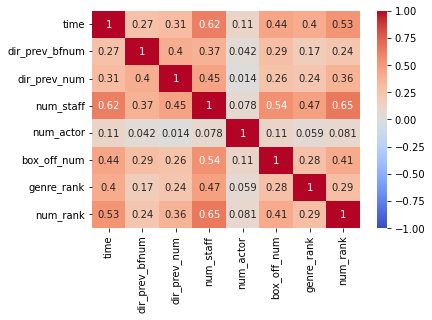

In [45]:
sns.heatmap(train.corr(), vmin=-1, vmax=+1, annot=True, cmap='coolwarm')

In [46]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from ngboost import NGBRegressor

C:\Users\shcho\anaconda3\envs\study\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 4. 모델링 데이터 구성
- 타겟 값인 관객수를 로그 변환
- 상영 등급은 더미 변수
- ~~출연 배우 수는 로그 변환~~  ➡ 출연배우 수는 빼준다.


### 나중에 추가로 해볼만한 사항
- 영화제작에 참여한 스태프 수도 로그 변환 ⬆
- 'dir_prev_bfnum' 컬럼과 'dir_prev_num' 컬럼도 사용하여 진행 ⬆
- 장르별 관객수를 랭크를 매기지 말고 관객수의 평균 값으로 Min-Max 정규화를 진행하면 어떨까
- 배급사별 관객수도 마찬가지

### 로그변환
**로그 함수의 특징**  
- 0 < x < 1 범위에서는 기울기가 매우 가파르다.
- 0에 가깝게 모여 있는 값들이 x로 입력되면, 그 함수값인 y 값들은 매우 큰 범위로 벌어진다.
- x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아진다.  

  
**np.log()가 아닌 np.log1p()인 이유** 

로그함수의 경우 자연로그 함수 그래프를 보면, x = 0 인 경우 y가 무한대의 값을 가진다.  
이를 해결하기 위한 방법으로 x + 1을 해줘서 0 -> 1 로 바꿔줘면 문제가 없게 된다.
np.log1p() 함수가 바로 이 역할을 한다.

In [47]:
# 모델링을 진행할 컬럼 선정
# 타겟 값인 관객 수 로그 변환

X = train[['num_rank', 'time', 'num_staff', 'dir_prev_bfnum', 'dir_prev_num', 'genre_rank', 'screening_rat']]
y = np.log1p(train.box_off_num)

In [48]:
# 상영등급 더미변수로 만들기
# 더미변수는 범주형 data를 Machine Learning 알고리즘에서 사용하기 위해
# 컴퓨터가 인식할 수 있는 형태로 만들어 주는 것

X = pd.get_dummies(columns = ['screening_rat'], data = X)

In [50]:
# 출연 배우 수 로그 변환
# X['num_actor'] = np.log1p(X['num_actor'])

# 스태프 수 로그 변환
X['num_staff'] = np.log1p(X['num_staff'])

# 이전 영화 평균 관객 수 로그 변환
X['dir_prev_bfnum'] = np.log1p(X['dir_prev_bfnum'])

In [61]:
X

,num_rank,time,num_staff,dir_prev_bfnum,dir_prev_num,genre_rank,screening_rat_12세 관람가,screening_rat_15세 관람가,screening_rat_전체 관람가,screening_rat_청소년 관람불가
0,134,96,4.521789,0.000000,0,11,0,0,0,1
1,145,130,5.961005,13.965312,2,12,0,0,0,1
2,145,123,5.840642,12.304905,4,11,0,1,0,0
3,140,101,3.044522,10.081425,2,9,0,0,1,0
4,145,108,5.529429,0.693147,1,9,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
595,140,111,6.236370,8.251664,1,8,0,0,0,1
596,145,127,5.659482,13.114456,1,8,0,1,0,0
597,46,99,4.820282,0.000000,0,7,0,0,0,1
598,141,102,6.068426,0.000000,0,12,0,1,0,0


In [51]:
target = test[['num_rank', 'time', 'num_staff', 'dir_prev_bfnum', 'dir_prev_num', 'genre_rank', 'screening_rat']]

In [52]:
target = pd.get_dummies(columns = ['screening_rat'], data = target)

In [53]:
# target['num_actor'] = np.log1p(target['num_actor'])
target['num_staff'] = np.log1p(target['num_staff'])
target['dir_prev_bfnum'] = np.log1p(target['dir_prev_bfnum'])

In [54]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)
# n_estimators=1000 : light gbm 특성상 들어간다고 한다.

# 5. 모델 학습 및 검증


a. lightGBM (base model)  

b. k-fold lightGBM (k-fold model)  

c. feature engineering (fe)  

d. grid serch (hyperparameter tuning)  


### LightGBM

- 부스팅 모델
- 기존 모델이 못 맞춘 문제에 가중치를 두어 지속적으로 학습을 이어나감
- 타 부스팅 모델에 비해 속도가 빠름

In [55]:
model.fit(X, y)

LGBMRegressor(n_estimators=1000, random_state=777)

In [56]:
singleLGBM = submission.copy()

In [57]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [58]:
singleLGBM['box_off_num'] = model.predict(target)

In [59]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,13.867854
1,아빠가 여자를 좋아해,14.892257
2,하모니,14.245099
3,의형제,14.470642
4,평행 이론,13.878933


In [60]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

### K-Fold로 교차검증
모델이 학습 데이터에만 과도하게 최적화 되는 것을 막기위해 별도의 여러 세트로 구성된 학습 데이터 세트와 검증 데이터 세트에서 학습과 평가를 수행하는 것.  

테스트 데이터셋에 대해 평가하는 게 수능이라고 하면, 교차검증에서 학습과 평가를 수행하는 것은 모의고사로 보면 된다.  

### Parameters
- **n_splits(필수)** : 분할하려는 개수 
- **shuffle(옵션)** : defalut=False이며, True일 때 데이터셋을 섞어서 분할
- **random_state(옵션)** : shuffle이 True일 때 동일한 셔플을 발생시키는 시드 값

In [62]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 777)

In [63]:
# 내가 설정한 n_splits대로 분할 된 것을 볼 수 있다.
for train_idx, val_idx in kf.split(X):
    print(len(train_idx), len(val_idx))
    break

540 60


### 설명
train set은 순차적으로 넣어주고 validation set은 eval_set에 tuple 형태로 넣어준다.  

boosting 모델이 못맞춘 문제를 지속적(반복적)으로 학습할 때그 과정에서 어느정도 일정 수준에 도달하면 그 이후 학습은 train 데이터 셋에 과적합이 될 수 있다.  
그래서 어느정도 시점이 되면 학습을 중단시킬 필요가 있다.  
그 중단 시키는 기준을 정해주는 게 early_stopping_rounds 이다.  

n_estimators=1000 => 1000번의 모델을 만들건데  
early_stopping_rounds=100 => 100번의 과정동안 유의미한 모델의 성능 증가가 관측되지 않는다면 학습을 멈춰라  

verbose=100 => 100번의 과정마다 모델에 대한 성능 값을 출력해달라

In [64]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

models = []   # 모델을 담는 바구니

# train set과 validation set을 나눈다.
for train_idx, val_idx in kf.split(X):
    x_t = X.iloc[train_idx]
    y_t = y.iloc[train_idx]
    x_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

C:\Users\shcho\anaconda3\envs\study\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shcho\anaconda3\envs\study\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 3.12874
[100]	valid_0's l2: 1.81124
[100]	valid_0's l2: 2.59067
[100]	valid_0's l2: 2.34666
[100]	valid_0's l2: 3.88514
[100]	valid_0's l2: 1.71062
[100]	valid_0's l2: 2.84533
[100]	valid_0's l2: 2.24379
[100]	valid_0's l2: 3.32628
[100]	valid_0's l2: 1.90504


In [65]:
models

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [66]:
# 예측한 10개의 모델들을 저장

preds = []
for model in models:
    preds.append(model.predict(target))
len(preds)

10

In [67]:
kfoldLightGBM = submission.copy()

In [68]:
preds

[array([14.1116115 , 13.83867163, 13.55968605, 14.39480223, 13.2974656 ,
         5.51717853,  8.09006776,  5.36737156,  8.04855268,  5.53355039,
        12.46485498, 12.47671903,  5.40631487,  7.93160608, 13.19411175,
        14.08998963,  8.10763668, 14.31013123, 11.11705374, 10.11922661,
         5.25471   ,  7.84701044,  8.27219512,  5.22640432,  5.37607134,
        13.18472708,  7.56189927, 13.49567658,  8.59464893,  5.52147516,
        13.21399484, 10.18072387,  8.19552224,  8.68305067,  8.11063979,
         7.39781207,  7.19582196,  7.75828196,  8.10648388,  4.9798139 ,
         5.60986627, 10.57271461, 11.58936714, 12.89361113, 12.13988683,
        13.13872835,  5.45209665,  5.58396681, 11.58918717,  5.3863864 ,
         7.30150949, 12.94854887,  8.50420751, 13.47793869, 13.91018468,
         5.45787304,  8.71360074, 13.28625445, 13.77545415, 14.21645599,
        12.92929741, 14.65065401,  8.31527103,  5.44339687,  8.04342649,
         5.35969948, 13.23811112, 10.0690615 , 11.6

In [69]:
# 평균값 구해서 저장
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0)

In [70]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,14.111611
1,아빠가 여자를 좋아해,13.838672
2,하모니,13.559686
3,의형제,14.394802
4,평행 이론,13.297466


In [71]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)

In [74]:
from sklearn.model_selection import GridSearchCV

In [76]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000)

params = {
    'learning_rate': [0.1, 0.01, 0.003],
    'min_child_samples': [20, 30]}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring='neg_mean_squared_error',
                  cv = kf)

In [77]:
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [78]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 20}

In [80]:
model = lgb.LGBMRegressor(random_state=777, n_estimators=1000, learning_rate=0.003, min_child_samples=30)

models = []

for train_idx, val_idx in kf.split(X):
    x_t = X.iloc[train_idx]
    y_t = y.iloc[train_idx]
    x_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set=(x_val, y_val), early_stopping_rounds=100, verbose=100))

C:\Users\shcho\anaconda3\envs\study\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\shcho\anaconda3\envs\study\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 6.92218
[200]	valid_0's l2: 5.0503
[300]	valid_0's l2: 4.02609
[400]	valid_0's l2: 3.44407
[500]	valid_0's l2: 3.1181
[600]	valid_0's l2: 2.94528
[700]	valid_0's l2: 2.86328
[800]	valid_0's l2: 2.83519
[900]	valid_0's l2: 2.84983
[100]	valid_0's l2: 5.97869
[200]	valid_0's l2: 4.05224
[300]	valid_0's l2: 3.09808
[400]	valid_0's l2: 2.59942
[500]	valid_0's l2: 2.35412
[600]	valid_0's l2: 2.23772
[700]	valid_0's l2: 2.17273
[800]	valid_0's l2: 2.14244
[900]	valid_0's l2: 2.13321
[100]	valid_0's l2: 8.88782
[200]	valid_0's l2: 6.54582
[300]	valid_0's l2: 5.18572
[400]	valid_0's l2: 4.38384
[500]	valid_0's l2: 3.88921
[600]	valid_0's l2: 3.55968
[700]	valid_0's l2: 3.30575
[800]	valid_0's l2: 3.15118
[900]	valid_0's l2: 3.02982
[1000]	valid_0's l2: 2.9555
[100]	valid_0's l2: 7.03791
[200]	valid_0's l2: 4.85391
[300]	valid_0's l2: 3.64353
[400]	valid_0's l2: 2.9522
[500]	valid_0's l2: 2.55398
[600]	valid_0's l2: 2.37374
[700]	valid_0's l2: 2.30521
[800]	valid_0's l2: 2.2

In [82]:
preds = []
for model in models:
    preds.append(model.predict(target))

In [83]:
gs.best_score_

-2.4672952014428793

In [84]:
gslgbm = submission.copy()

In [85]:
gslgbm['box_off_num'] = np.mean(preds, axis=0)

In [86]:
gslgbm.to_csv('gslgbm.csv', index=False)

# 궁금한점

1. 일반적으로 데이터프레임의 한 컬럼을 지칭할 때 train['box_off_num'] 이렇게 쓰는데  train.box_off_num 이렇게 써도 되는 것 같고 이렇게 썼을 때 차이점은? 
2. for train_idx, val_idx in kf.split(X) 여기서 인자로 X만 넣어주는 것과, y도 같이 인자를 2개 넣어주는 것은 어떤 차이가 있는가?

**title** : 영화의 제목  

**distributor** : 배급사  

**genre** : 장르  

**release_time** : 개봉일  

**time** : 상영시간(분)  

**screening_rat** : 상영등급  

**director** : 감독이름  

**dir_prev_bfnum** : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수  
(단 관객수가 알려지지 않은 영화 제외)  

**dir_prev_num** : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수  
(단 관객수가 알려지지 않은 영화 제외)  

**num_staff** : 스텝수  

**num_actor** : 주연배우수  

**box_off_num** : 관객수  
